<a href="https://colab.research.google.com/github/rarodrigo-datasc/spark/blob/main/tre_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Preparação do Ambiente

### 1.1 Instalar as dependências para **Spark**

* openjdk-8-jdk-headless: biblioteca `java` sem interface gráfica usada pelo Spark
* findspark: a biblioteca Python `findspark` facilita a integração do Spark com o ambiente Python.

In [61]:
!apt update -qq
!apt upgrade -y
!apt install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

4 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Calculating upgrade... Done
The following packages have been kept back:
  libcudnn8 libcudnn8-dev libnccl-dev libnccl2
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.




### 1.2 Configurar as variáveis de ambiente

In [62]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

### 1.3 Inicializar o módulo `findspark`

Configura o ambiente Python para encontrar os módulos e bibliotecas do Spark.

In [63]:
import findspark
findspark.init('spark-3.1.2-bin-hadoop2.7')


## 2. Preparação dos Dados

### 2.1 Configurar SparkSession

* Criar uma sessão spark para interagir com os dados usando DataFrames e Datasets;


In [64]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName("tre-spark").config('spark.ui.port', '4050').getOrCreate()


### 2.2 Carregar os dados

Procedimento manual

* Fazer download da base de dados em `https://github.com/rarodrigo-datasc/spark/blob/01a70477f37903a69efeae7b95d98456aaf3112b/tre_qualificado.zip`
* Fazer upload da base de dados para o projeto;

Extração da base

* Extrair a base de dados no formato ".zip";
* Ler os dados extraídos.

In [65]:
import zipfile
zipfile.ZipFile('./tre_qualificado.zip').extractall()


In [66]:
df = spark.read.csv('./tre_qualificado.csv', sep=';', encoding='utf-8', header=True)
df.printSchema()
df.show()


root
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: string (nullable = true)
 |-- NR_SECAO: string (nullable = true)
 |-- NR_LOCAL_VOTACAO: string (nullable = true)
 |-- QT_APTOS: string (nullable = true)
 |-- QT_COMPARECIMENTO: string (nullable = true)
 |-- QT_ABSTENCOES: string (nullable = true)

+------------+-------+--------+----------------+--------+-----------------+-------------+
|NM_MUNICIPIO|NR_ZONA|NR_SECAO|NR_LOCAL_VOTACAO|QT_APTOS|QT_COMPARECIMENTO|QT_ABSTENCOES|
+------------+-------+--------+----------------+--------+-----------------+-------------+
|      CUIABÁ|      1|     147|            1015|     153|              132|           21|
|      CUIABÁ|      1|     149|            1015|     152|              134|           18|
|      CUIABÁ|      1|     150|            1015|     156|              134|           22|
|      CUIABÁ|      1|     154|            1260|     324|              273|           51|
|      CUIABÁ|      1|     156|            1015|     159|  

## 3. Estatísticas

* Verificar a quantidade de valores nulos em cada coluna
* Verificar o tipo de campo

In [67]:
# Verificar se as colunas possuem valores nulos
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

df.printSchema()


+------------+-------+--------+----------------+--------+-----------------+-------------+
|NM_MUNICIPIO|NR_ZONA|NR_SECAO|NR_LOCAL_VOTACAO|QT_APTOS|QT_COMPARECIMENTO|QT_ABSTENCOES|
+------------+-------+--------+----------------+--------+-----------------+-------------+
|           0|      0|       0|               0|       0|                0|            0|
+------------+-------+--------+----------------+--------+-----------------+-------------+

root
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: string (nullable = true)
 |-- NR_SECAO: string (nullable = true)
 |-- NR_LOCAL_VOTACAO: string (nullable = true)
 |-- QT_APTOS: string (nullable = true)
 |-- QT_COMPARECIMENTO: string (nullable = true)
 |-- QT_ABSTENCOES: string (nullable = true)



## 4. Transformação de Dados

* Transformar os dados do tipo string para inteiro

In [68]:
# Transformar as colunas do tipo string para inteiro
from pyspark.sql.types import IntegerType

df = df.withColumn("NR_ZONA", df["NR_ZONA"].cast(IntegerType()))
df = df.withColumn("NR_SECAO", df["NR_SECAO"].cast(IntegerType()))
df = df.withColumn("NR_LOCAL_VOTACAO", df["NR_LOCAL_VOTACAO"].cast(IntegerType()))
df = df.withColumn("QT_APTOS", df["QT_APTOS"].cast(IntegerType()))
df = df.withColumn("QT_COMPARECIMENTO", df["QT_COMPARECIMENTO"].cast(IntegerType()))
df = df.withColumn("QT_ABSTENCOES", df["QT_ABSTENCOES"].cast(IntegerType()))
df.printSchema()


root
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: integer (nullable = true)
 |-- NR_SECAO: integer (nullable = true)
 |-- NR_LOCAL_VOTACAO: integer (nullable = true)
 |-- QT_APTOS: integer (nullable = true)
 |-- QT_COMPARECIMENTO: integer (nullable = true)
 |-- QT_ABSTENCOES: integer (nullable = true)



## 5. Aplicação

#### 5.1 `Local de Votação` X `Aptos, Comparecimentos e Abstenções`

* Somar o número de aptos, de comparecimentos e de abstenções para cada local de votação

In [69]:
## prompt: agrupar os dados por local de votação e somar a quantidade de aptos a votar
# from pyspark.sql import functions as F # Import the functions module

from pyspark.sql.functions import sum

# Agrupe por NR_LOCAL_VOTACAO e calcule a soma de QT_APTOS
df_grouped = df.groupBy("NR_LOCAL_VOTACAO")

df_soma = df_grouped.agg(
    sum("QT_APTOS").alias("QT_APTOS"),
    sum("QT_COMPARECIMENTO").alias("QT_COMPARECIMENTO"),
    sum("QT_ABSTENCOES").alias("QT_ABSTENCOES")
    )

# Exiba o resultado
df_soma.show()

+----------------+--------+-----------------+-------------+
|NR_LOCAL_VOTACAO|QT_APTOS|QT_COMPARECIMENTO|QT_ABSTENCOES|
+----------------+--------+-----------------+-------------+
|            1139|   40098|            30541|         9557|
|            2488|    4450|             3619|          831|
|            2259|    2155|             1757|          398|
|            2739|    1270|             1082|          188|
|            1198|   18069|            13572|         4497|
|            2003|    8099|             6561|         1538|
|            1031|  144506|           107379|        37127|
|            1201|   31247|            24115|         7132|
|            1163|   48397|            36531|        11866|
|            2682|    1994|             1670|          324|
|            1708|    5109|             4247|          862|
|            2240|    1410|             1215|          195|
|            2526|    2244|             1956|          288|
|            1350|    8931|             

#### 5.2 Gráficos de Pizza

* Para cada local de votação, exibir um gráfico comparando o número de comparecimentos e abstenções

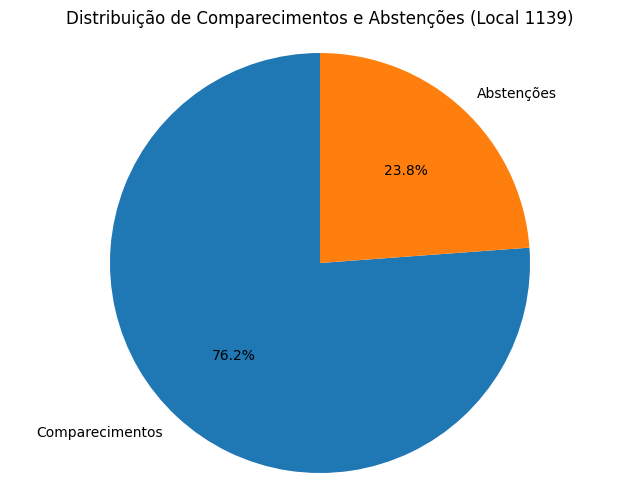

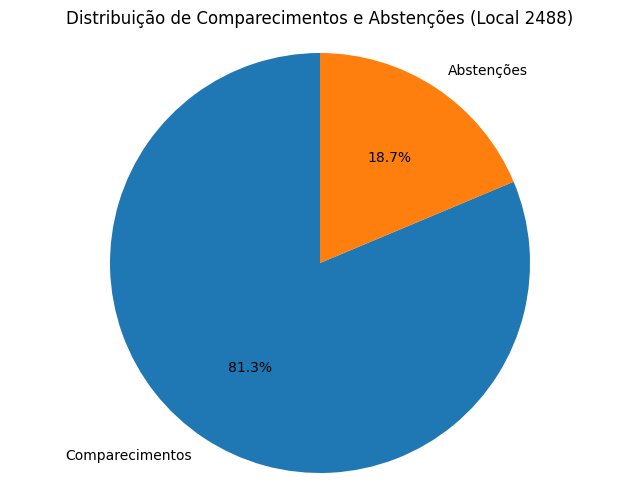

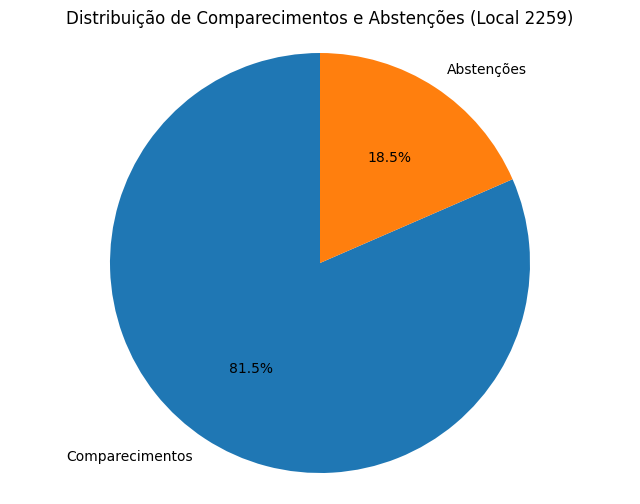

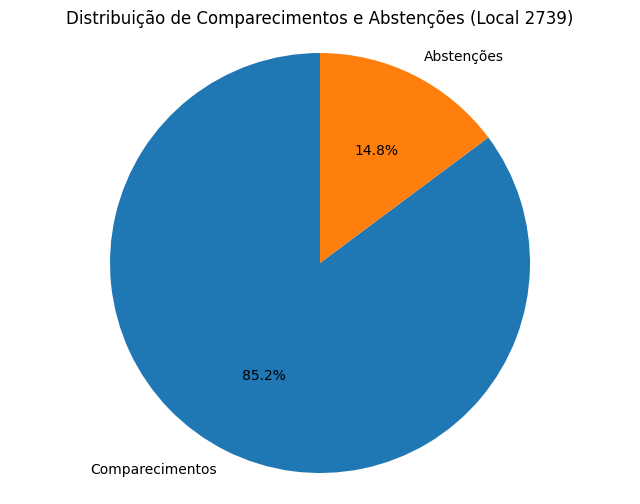

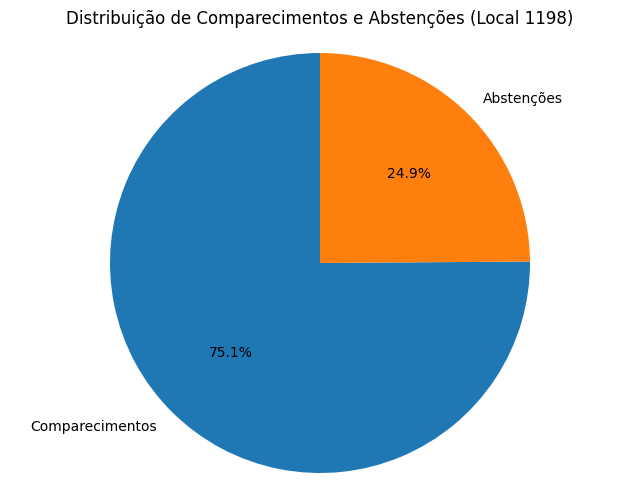

In [70]:
# Suponha que 'df' seja o seu DataFrame com as colunas desejadas
# Filtrar para cada NR_LOCAL_VOTACAO
local_votacao_list = df.select("NR_LOCAL_VOTACAO").distinct().collect()

for i, local in enumerate(local_votacao_list):
    if i >= 5:
        break  # Stop after the first 5 locations
    local_id = local["NR_LOCAL_VOTACAO"]
    df_filtered = df.filter(col("NR_LOCAL_VOTACAO") == local_id)

    # Selecione as colunas relevantes
    df_selected = df_filtered.select("QT_COMPARECIMENTO", "QT_ABSTENCOES")

    # Converta o DataFrame para Pandas para plotagem
    df_pandas = df_selected.toPandas()

    # Crie o gráfico de pizza
    plt.figure(figsize=(8, 6))
    plt.pie(df_pandas.sum(), labels=["Comparecimentos", "Abstenções"], autopct="%1.1f%%", startangle=90)
    plt.title(f"Distribuição de Comparecimentos e Abstenções (Local {local_id})")
    plt.axis("equal")  # Para garantir que o gráfico seja circular
    plt.show()